In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [2]:
stock_price_df = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")

In [3]:
print('(rows, columns) =', stock_price_df.shape)
stock_price_df.tail()

(rows, columns) = (2332531, 12)


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098
2332530,20211203_9997,2021-12-03,9997,690.0,711.0,686.0,696.0,381100,1.0,NaN,False,0.018414


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, input_size=8, sequence_num=31, lstm_dim=128,
                 num_layers=2, output_size=1):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, lstm_dim, num_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(lstm_dim*sequence_num*2, 1)
        self.bn1 = nn.BatchNorm1d(lstm_dim*sequence_num*2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out.reshape(lstm_out.shape[0], -1)
        x = self.linear1(self.bn1(x))
        return x

In [5]:
stock_price_df['ExpectedDividend'] = stock_price_df['ExpectedDividend'].fillna(0)
stock_price_df['SupervisionFlag'] = stock_price_df['SupervisionFlag'].map({True: 1, False: 0})
stock_price_df['Date'] = pd.to_datetime(stock_price_df['Date'])
stock_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   RowId             object        
 1   Date              datetime64[ns]
 2   SecuritiesCode    int64         
 3   Open              float64       
 4   High              float64       
 5   Low               float64       
 6   Close             float64       
 7   Volume            int64         
 8   AdjustmentFactor  float64       
 9   ExpectedDividend  float64       
 10  SupervisionFlag   int64         
 11  Target            float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(1)
memory usage: 213.5+ MB


In [6]:
stock_price_df = stock_price_df.dropna(how='any')
# Confirmation of missing information
stock_price_df_na = (stock_price_df.isnull().sum() / len(stock_price_df)) * 100
stock_price_df_na = stock_price_df_na.drop(stock_price_df_na[stock_price_df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :stock_price_df_na})
missing_data.head(22)

,Missing Ratio


In [7]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag']
stock_price_df[columns] = stdsc.fit_transform(stock_price_df[columns])
stock_price_df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,0.038994,0.035493,0.047764,0.041374,-0.169192,-0.007493,-0.053484,-0.014769,0.000730
1,20170104_1332,2017-01-04,1332,-0.566509,-0.566547,-0.565510,-0.565637,0.537161,-0.007493,-0.053484,-0.014769,0.012324
2,20170104_1333,2017-01-04,1333,0.155286,0.161205,0.163796,0.172227,-0.108081,-0.007493,-0.053484,-0.014769,0.006154
3,20170104_1376,2017-01-04,1376,-0.303174,-0.297439,-0.297504,-0.291909,-0.174323,-0.007493,-0.053484,-0.014769,0.011053
4,20170104_1377,2017-01-04,1377,0.188832,0.199886,0.200587,0.205779,-0.138713,-0.007493,-0.053484,-0.014769,0.003026


In [8]:
dataset_dict = {}
for sc in stock_price_df['SecuritiesCode'].unique():
    dataset_dict[str(sc)] = stock_price_df[stock_price_df['SecuritiesCode'] == sc].values[:, 3:].astype(np.float32)
print(dataset_dict['1301'].shape)

(1201, 9)


In [9]:
from torch.utils.data.sampler import SubsetRandomSampler
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, sequence_num=31, y=None, mode='train'):
        self.data = X
        self.teacher = y
        self.sequence_num = sequence_num
        self.mode = mode
    def __len__(self):
        return len(self.teacher)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        if self.mode == 'train':
            out_label =  self.teacher[idx[-1]]
            return out_data, out_label
        else:
            return out_data
def create_dataloader(dataset, dataset_num, sequence_num=31, input_size=8, batch_size=32, shuffle=False):
    sampler = np.array([list(range(i, i+sequence_num)) for i in range(dataset_num-sequence_num+1)])
    if shuffle == True:
        np.random.shuffle(sampler)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)
    return dataloader
#### Check operation ####
X_check, y_check = dataset_dict['1301'][:, :-1], dataset_dict['1301'][:, -1]
dataset_check = MyDataset(X_check, y=y_check, sequence_num=31, mode='train')
dataloader_check = create_dataloader(dataset_check, X_check.shape[0], sequence_num=31, input_size=8, batch_size=32, shuffle=False)
for b, tup in enumerate(dataloader_check):
    print('---------')
    print(tup[0].shape, tup[1].shape)
    break

---------
torch.Size([32, 31, 8]) torch.Size([32])


In [10]:
from tqdm import tqdm
epochs = 10
batch_size = 512
# Check wheter GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Model Instantiation
model = LSTM(input_size=8, sequence_num=31, lstm_dim=128, num_layers=2, output_size=1)
model.to(device)
model.train()
# setting optimizer
lr = 0.0001
weight_decay = 1.0e-05
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)
# setting criterion
criterion = nn.MSELoss()
# set iteration counter
iteration = 0
# 
log_train = [[0], [np.inf]]
for epoch in range(epochs):
    epoch_loss = 0.0
    for sc in tqdm(stock_price_df['SecuritiesCode'].unique()):
        X, y = dataset_dict[str(sc)][:, :-1], dataset_dict[str(sc)][:, -1]
        dataset = MyDataset(X, y=y, sequence_num=31, mode='train')
        dataloader = create_dataloader(dataset, X.shape[0], sequence_num=31, input_size=8, batch_size=batch_size, shuffle=True)
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            data = data.to(torch.float32)
            output = model.forward(data)
            targets = targets.to(torch.float32)
            
            loss = criterion(output.view(1,-1)[0], targets)
            
            loss.backward()
            
            optimizer.step()
            
            epoch_loss += loss.item()
            
            iteration += 1
    epoch_loss /= iteration
    print('epoch_loss={}'.format(epoch_loss))
    log_train[0].append(iteration)
    log_train[1].append(epoch_loss)

100%|██████████| 2000/2000 [01:47<00:00, 18.64it/s]


epoch_loss=0.003735576762897113


100%|██████████| 2000/2000 [01:46<00:00, 18.81it/s]


epoch_loss=0.00102579251111847


100%|██████████| 2000/2000 [01:45<00:00, 18.90it/s]


epoch_loss=0.0005804501130058418


100%|██████████| 2000/2000 [01:45<00:00, 18.87it/s]


epoch_loss=0.00039218660293389746


100%|██████████| 2000/2000 [01:45<00:00, 18.93it/s]


epoch_loss=0.00029446537321374885


100%|██████████| 2000/2000 [01:46<00:00, 18.85it/s]


epoch_loss=0.0002291114349804186


100%|██████████| 2000/2000 [01:46<00:00, 18.83it/s]


epoch_loss=0.0001881660559168414


100%|██████████| 2000/2000 [01:46<00:00, 18.70it/s]


epoch_loss=0.00015819012146721785


100%|██████████| 2000/2000 [01:46<00:00, 18.81it/s]


epoch_loss=0.00013707769888671428


100%|██████████| 2000/2000 [01:46<00:00, 18.82it/s]

epoch_loss=0.0001186204229194607


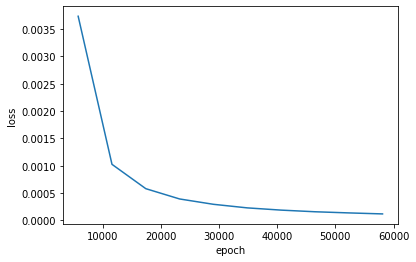

In [11]:
import matplotlib.pyplot as plt
plt.plot(log_train[0][1:], log_train[1][1:])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [12]:
from datetime import datetime
def predict(model, X_df, sequence=31):
    pred_df = X_df[['Date', 'SecuritiesCode']]
    # Grouping by `groupby` and retrieving one by one
    code_group = X_df.groupby('SecuritiesCode')
    X_all = np.array([])
    for sc, group in code_group:
        # Standardize target data
        group_std = stdsc.transform(group[columns])
        # Calling up past data of the target data
        X = dataset_dict[str(sc)][-1*(sequence-1):, :-1]
        # concat
        X = np.vstack((X, group_std))
        X_all = np.append(X_all, X)
    X_all = X_all.reshape(-1, sequence, X.shape[1])
    y_pred = np.array([])
    for it in range(X_all.shape[0]//512+1):
        data = X_all[it*512:(it+1)*512]
        data = torch.from_numpy(data.astype(np.float32)).clone()
        data = data.to(torch.float32)
        data = data.to(device)
        output = model.forward(data)
        output = output.view(1, -1)
        output = output.to('cpu').detach().numpy().copy()
        y_pred = np.append(y_pred, output[0])
    pred_df['target'] = y_pred
    pred_df['Rank'] = pred_df["target"].rank(ascending=False,method="first") -1
    pred_df['Rank'] = pred_df['Rank'].astype(int)
    pred_df = pred_df.drop('target', axis=1)
    return pred_df
test_X_df = stock_price_df[stock_price_df['Date'] == datetime(2021, 12, 3)].drop('Target', axis=1)
y_pred = predict(model, test_X_df)
print(y_pred.shape)
print(y_pred)

(1995, 3)
              Date  SecuritiesCode  Rank
2330531 2021-12-03            1301  1660
2330532 2021-12-03            1332    89
2330533 2021-12-03            1333  1444
2330534 2021-12-03            1375   778
2330535 2021-12-03            1376   695
...            ...             ...   ...
2332526 2021-12-03            9990   626
2332527 2021-12-03            9991   667
2332528 2021-12-03            9993  1173
2332529 2021-12-03            9994  1506
2332530 2021-12-03            9997   570

[1995 rows x 3 columns]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [13]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [14]:
count = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    prices = prices.fillna(0)
    prices['SupervisionFlag'] = prices['SupervisionFlag'].map({True: 1, False: 0})
    prices['Date'] = pd.to_datetime(prices['Date'])
    pred_df = predict(model, prices)
    print(pred_df)
    env.predict(pred_df)
    count += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

           Date  SecuritiesCode  Rank
0    2021-12-06            1301  1566
1    2021-12-06            1332   107
2    2021-12-06            1333  1362
3    2021-12-06            1375   712
4    2021-12-06            1376   623
...         ...             ...   ...
1995 2021-12-06            9990   347
1996 2021-12-06            9991   405
1997 2021-12-06            9993   970
1998 2021-12-06            9994  1374
1999 2021-12-06            9997   390

[2000 rows x 3 columns]
           Date  SecuritiesCode  Rank
0    2021-12-07            1301  1563
1    2021-12-07            1332    53
2    2021-12-07            1333  1363
3    2021-12-07            1375   721
4    2021-12-07            1376   629
...         ...             ...   ...
1995 2021-12-07            9990   344
1996 2021-12-07            9991   406
1997 2021-12-07            9993   963
1998 2021-12-07            9994  1373
1999 2021-12-07            9997   395

[2000 rows x 3 columns]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab